# KeepUp Data Analysis Exercise

This exercise analyzes data from the Amazon data set (http://snap.stanford.edu/data/amazon-meta.html) in order to draw cocnlusions about ratings and categorization of products.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re

In [80]:
import collections

## A1. Trustworthiness of Ratings 

Q: With the given data for 548552 products, perform exploratory analysis and make suggestions for further analysis on the following aspects. Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively speaking) about the ratings in this dataset?

To answer this question, we will import the 'avg rating' score for each product and make a histiogram of results. The original file will be screened line by line for the 'avg rating' field and the rating extracted. Due to teh size of the data set, it is sufficient to look at average ratings per product, rather than at all ratings given by individual users.

In [70]:
%%time
# initialize empty list
ratings = []
# extract the rating from the 'avg rating :' line and add to the list
with open('amazon-meta.txt', 'r') as f:
    for line in f:
        rating = re.search(r'(\bavg rating: \b)([1-5])', line)
        if rating is not None:
            ratings.append(int(rating.group(2)))

Wall time: 1min 9s


In [71]:
len(ratings)

402735

This only extracted 402k ratings vs. 548k products. Some products are not rated or discontinued.

In [72]:
#check unique values and value counts:
np.unique(ratings, return_counts=True)

(array([1, 2, 3, 4, 5]),
 array([  3569,  10678,  55632, 187021, 145835], dtype=int64))

In [78]:
np.mean(ratings)

4.1443629185444522

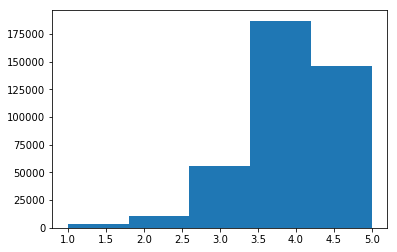

In [77]:
# plot histogram
plt.hist(ratings, bins=5)
plt.show()

The distribution of ratings is positively skewed, i.e. there are more high ratings (4 and 5) than low/mid ratings (1-2 as low and 3 as mid). The mean rating is 4.14. 

## A2. Category Bloat 

This section focuses on the Books cateory and analyzes the structure and distribution of categories. The questions we are trying to answer are: 
a. Is there redundancy in the categorization? How can it be identified/removed?
b. Is is possible to reduce the number of categories drastically (say to 10% of existing 
categories) by sacrificing relatively few category entries (say close to 10%)?

First, we will read teh source file line by line and identify the lines which describe the categorization for each product. Each category is represented by an integer code, which we will add to a counter and extract the number of times each category appears in the data set. Note that a book typically has 3-4 different categories assigned to it and each of these is hierarchically divided over about 4 levels, from teh broadest to teh most detailed. 

Next, we will look at the distribution of final-branch (most detailed) categories and explore if there is a large number of categories that appear with low frequency. We can define redundancy as a category that has very few titles attached to it and therefore represents unnecessasy complexity and does not help customers find these titles by secluding them in categories that are too specialized. The exact cut-off point is a question of judgement, but we can safely assume that a category with 1-2 entries is definitely redundant, while a category with 100+ entries is not. A sensible cut-off may be e.g. 10 or 20 titles per category.

In [394]:
%%time
# initialize empty counter
categories_list = []
# find the relevant line and extract codes that relate to categories
with open('amazon-meta.txt', 'r') as f:
    for line in f:
        m = re.search(r'\bBooks\b\[\d+\]', line)
        if m is not None:
            n = re.findall(r'\d+', m.string)
            categories_list.append(n)

Wall time: 1min 16s


In [397]:
categories_list[-10:]

[['283155', '1000', '10', '298657'],
 ['283155', '1000', '3', '2665', '2669'],
 ['283155', '1000', '10777', '173486', '10903'],
 ['283155', '1000', '10777', '173483', '10963'],
 ['283155', '1000', '5', '3510', '3525', '3527'],
 ['283155', '1000', '5', '4134', '549650', '4137', '4142'],
 ['265523', '285080', '764512', '768162', '768228', '768256', '768322'],
 ['283155', '1000', '53', '11232', '11288', '11289'],
 ['283155', '1000', '22', '12290', '12292', '12295'],
 ['283155', '1000', '75', '13871', '13872']]

In [413]:
last_items = []
for list in categories_list:
    li =  list[-1]
    last_items.append(li)
len(last_items)

1437865

In [420]:
items = 0
for list in categories_list:
    items += len(list)
items

7961434

In [416]:
categories = collections.Counter(last_items)

In [417]:
no_categories = len(categories.keys())
no_entries = np.sum(categories.values())
print 'Total categories: ', no_categories
print 'Total entries: ', no_entries
print 'Ratio: ', no_entries / float(no_categories)

Total categories:  12524
Total entries:  1437865
Ratio:  114.808767167


In [421]:
# average no. of branches per entry
items / float(no_entries)

5.5369829573708245

In [419]:
# average no. of entries per book title
no_books = 393561 #from the data set web page, total no. of products
float(no_entries) / no_books

3.653474302585876

In [422]:
freq = np.sort(categories.values())

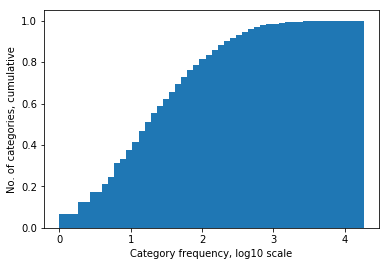

In [449]:
plt.hist(np.log10(freq), bins=50, cumulative=True, log=False, normed=True)
plt.xlabel('Category frequency, log10 scale')
plt.ylabel('No. of categories, cumulative')
plt.show()

In [447]:
# check where frequency of 20 entries is on the x-axis
np.log10(20)

1.3010299956639813

From the cumulative histogram we can visualize the distribution of category frequencies:
 - categories that appear 10 times or fewer (value 1 on the x-axis) account for just under 40% of all categories
 - 0.5 on the y-axis (i.e. half of all categories) seem to be at approx. 1.3 on the x-axis, so at frequency of approx. 20

In [423]:
# check the first entry (leat frequent) and last entry (most frequent) 
print freq[-1]
print freq[1]

18439
1


In [424]:
# sum the entries of the top 10% of categories (top 1252 entries)
# calculate the proportion of total entries
top10pct_categories = np.sum(freq[-1252:])
print top10pct_categories
print top10pct_categories / float(total_entries)

1025537
0.713235943569


The top 125 categories (i.e. top 10% of all Books categories) account for 440k entries or 30% of the total. So we cannot conclude that the top 10% of categories account for 90% of the products. The entries around the 10th percentile category have >1,400 entries. Next, we can look at the top 20% and top 50% of categories:

In [425]:
0.2*total_categories

2504.8

In [426]:
# sum the entries of the top 20% of categories (top 125 entries)
# calculate the proportion of total entries
print 'Top 20% of categories as % of total entries:', np.sum(freq[-2504:]) / float(total_entries)
print 'Top 50% of categories as % of total entries:', np.sum(freq[-6262:]) / float(total_entries) 

Top 20% of categories as % of total entries: 0.851379649689
Top 50% of categories as % of total entries: 0.970592510423


In [427]:
print '10th percentile frequency: ', freq[-1252]
print '20th percentile frequency: ', freq[-2504]
print '50th percentile frequency: ', freq[-6262]

10th percentile frequency:  245
20th percentile frequency:  101
50th percentile frequency:  18


In [436]:
freq[4730:4735]

array([10, 10, 10, 10, 11])

In [438]:
print 'percentage of 10 entries and below: ' ,np.sum(freq[:4735]) / float(total_entries) 
print 'percentage of categories that have 10 or fewer entries: ', 4735.0 / total_categories

percentage of 10 entries and below:  0.0146015098775
percentage of categories that have 10 or fewer entries:  0.378074097732


From the calculations above we have a better overall picture:
- The total number of Books available (from the web description) is 393k
- There are 1.29m entries starting with the word 'Book', which we used to identify the relevant lines in the .txt file
- In the vast majority of cases (95%) there is a Book category code and a Subject code (always the same codes), and on average there are 4 category branches
- Looking at the final branch, there are 12,524 distinct categories. 

In order to determine if there is category bloat present, we look at the distribution of entries over the 12,524 final branch categories:
- To determine of there is a 90/10 split present, we look at the top 10% of categories (1,205 categories) - these cover 1.0M entries, or 71% of the total. So in this final category branch there is no 90/10 split, but we can see that the distribution may lean towards a 80/20 split
- The top 20% of categories account for 85% of the total entries, and the top 50% of categories account for 97% of all entries. Hence we can conclude that there is some redundancy within the lower half of the distribution.
- To determone at what point a category might be considered redundant, we can look at the frequency of appearance at various points of the distribution: at the 10th percentile, a category appears 245 times, at the 20th 101 times and at the 50th 18 times. A common-sense argument may be that 100+ appearances do justify the existence of a category and provides a level of detailed categorization that helps users search for relatively specialized items. However at the 50th percentile categories appear under 20 times and it could be argued that categories may be redundant at e.f. under 20 or under 10 titles per category.

To answer the original question concisely:
a) There does seem to be some redundancy in the categorization, identified by looking for categories with low frequency. These can be removed by either merging with another final-branch category, or by eliminating these categories and keeping the titles at one hierarchical level above.
b) It would not be possible to remove 90% of categories and only affect 10% of the category entries. However, we can set a redundancy threshold based on the minimum number of entries per category, or the percentage of categories we wish to remove: 
 - with a threshold of 11 entries or more, it would be possible to remove 38% of categories and only affect 1.5% of entries 
 - by removing the bottom 50% of categories, only 3% of entries would be affected

## B1. Algorithm Thinking 

Q: How would build the product categorization from scratch, using similar/co-purchased information?  

A: The first 2-3 levels of 'broad' hirerarchical categorization would be best done using domain knowledge of how books are categorized (libabry or bookstore systems) as this would be familiar to customers. For the deeper levels, we could use unsupervised clustering methods for each broad category to create sub-levels of categories based on features about the titles (usually an abstract would provide info on what the title is about), in conjunction with co-purchased information to decide which products are most similar to each other. To avoid redundancy, conditions can be set on algorithms to produce clusters of a certain minimum size.

Specific algorithms that would be most suitable:
- Affinity propagation: allows many clusters and uneven cluster sizes
- Ward hierarchical clustering as it produces the hierarchies in one go, and is suitable for a large number of clusters

## B2. Product Thinking 

Q: Now, put on your 'product thinking' hat.
a. Is it a good idea to show users the categorization hierarchy for items? 
b. Is it a good idea to show users similar/co-purchased items? 
c. Is it a good idea to show users reviews and ratings for items? 
d. For each of the above, why? How will you establish the same?

A: All of the above are useful to show users:
- categorization hierarchy facilitates the user's navigation when searching for the right items and lets them know that they are in the products map. In this way they can browse related categories on the same broader topic and may be compelled to purchase more products in order to gain a better perspective. If only shown similar anc co-purchased items, the user is seeing more of the same and less variety. Also it is hard to imagine a user being discouraged from making a purchase purely on teh basis of being shown the hierarchical categorization as a very familiar concept.
- Similar and co-purchased products are also very useful for customers as they are given choice within the same category and suggestions on what items may also be of interest. It may be the case that showing suggestions from completely unrelated categories (just because a previous shopper bought unrelated items together) may be a poor idea, however this would need to be supporthed by data, such as an A/B test to show what level of similarity works best.
- Reviews and ratings are also useful to show as they help users decide what product is right for them. It would be reasonable to expect that users will be drawn to higher-rated products and so low-rated products would be either dropped from the seller's offer or ignored by users. This may be a reason why ratings have a positive skew.

For detrmining whether a feature is actually useful, we can use existing data to infer their imortance (e.g. by looking at the proportion of purchases that directly result from similar / co=purchased items). Alternatively, A/B testing can provide answers whether users prefer to have a feature or not.
